In [12]:
!pip install gym[all]
!pip install gym[accept-rom-license]
!pip install gym[classic_control]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gym
import numpy as np

In [14]:
# check and use GPU if available if not use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:

# create replay buffer of tuples of (state, next_state, action, reward, done)
# Initially keep storing the samples in the Buffers, then start sampling from it for getting IID Samples
class ReplayBuffer():
    def __init__(self, max_size=1e6):
        
        self.max_size = max_size # Max size of Replay Buffer
        self.storage = []
        self.pointer = 0

    def add(self, data):
        if len(self.storage) == self.max_size:
            self.storage[int(self.pointer)] = data
            self.pointer = (self.pointer + 1) % self.max_size
        else:
            self.storage.append(data)

    def sample(self, batch_size):
        uniform_samples = np.random.randint(0, len(self.storage), size=batch_size) # pi
        x, y, u, r, d = [], [], [], [], []

        for i in uniform_samples : 
            X, Y, U, R, D = self.storage[i] # Using Optimal Control terminology--> 
            u.append(np.array(U, copy=False))# Control Uk ( the optimal control term for Action )
            r.append(np.array(R, copy=False)) # reward 
            d.append(np.array(D, copy=False)) # Buffer size of Replay Buffer
            x.append(np.array(X, copy=False)) # Xk - current state
            y.append(np.array(Y, copy=False))
            

        return np.array(x), np.array(y), np.array(u).reshape(-1,1), np.array(r).reshape(-1,1), np.array(d).reshape(-1,1)

In [16]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, state_size, action_space_size, hidden_layer_size):
        super(MultiLayerPerceptron, self).__init__()
        self.fc_1 = nn.Linear(state_size, hidden_layer_size)
        #self.fc1_bn=nn.BatchNorm1d(hidden_layer_size)
        self.fc_2 = nn.Linear(hidden_layer_size, hidden_layer_size)
        #self.fc2_bn=nn.BatchNorm1d(hidden_layer_size)
        self.output = nn.Linear(hidden_layer_size, action_space_size)
    
    def forward(self, x):
        x=self.fc_1(x)
        x=F.relu(x)
        x=self.fc_2(x)
        x=F.relu(x)
        return self.output(x)

In [17]:
class MountainCarAgent():
    def __init__(self, state_size, action_space_size, hidden_layer_size, learning_rate ):
        
        self.action_space_size = action_space_size
        self.train_net = MultiLayerPerceptron(state_size, action_space_size, hidden_layer_size).to(device)
        self.target_net = MultiLayerPerceptron(state_size, action_space_size, hidden_layer_size).to(device)
        self.target_net.load_state_dict(self.train_net.state_dict())
        self.optimizer = optim.Adam(self.train_net.parameters(), lr=learning_rate)

        
    def select_action(self, state, epsilon):
        # select action according to epsilon-greedy method
        if np.random.rand() <= epsilon:
            action = env.action_space.sample()
        else:
            # greedy action is the largest Q value from the train network based on the input
            with torch.no_grad():
                input_state = torch.FloatTensor(state).to(device)
                # feed input into the network and get the max action value
                action = self.train_net(input_state).max(0)[1].view(-1)
                action = int(action)
        return action

    
    def train(self, replay_buffer, batch_size, discount):
        # train the training network
        # sample a batch from the replay buffer
        x0, x1, action, reward, done = replay_buffer.sample(batch_size)

        # turn batches into tensors and attack to GPU if available
        state_batch = torch.FloatTensor(x0).to(device)
        next_state_batch = torch.FloatTensor(x1).to(device)
        action_batch = torch.LongTensor(action).to(device)
        reward_batch = torch.FloatTensor(reward).to(device)
        done_batch = torch.FloatTensor(1 - done).to(device)

        # get train net Q values
        train_q = self.train_net(state_batch).gather(1, action_batch)
        
        # get target net Qvalues
        with torch.no_grad():
            target_net_q = reward_batch + done_batch * discount * \
                     torch.max( self.target_net(next_state_batch).detach(), dim=1)[0].view(batch_size, -1)

        # create loss function
        loss_fn = nn.MSELoss()
        # get loss between train q values and target q values
        loss = loss_fn(train_q, target_net_q)
        # optimize the parameters with the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        # we return the loss so we can monitor loss and debug the network if necessary
        return loss.detach().cpu().numpy()
    
    
    def update_target_network(self, num_iter, update_every):
        # update target network every so often
        # hard target network update: updates target network fully with train network params
        if num_iter % update_every == 0:
            self.target_net.load_state_dict(self.train_net.state_dict())

# Hyperparameter

In [18]:
# initialize environment
env = gym.make("MountainCar-v0")
action_size = env.action_space.n
state_size = env.observation_space.shape[0]
print('Action Space-->',env.action_space)
print('Observation Space-->',env.observation_space)
print('reward range-->',env.reward_range)
print('Meta data --> ',env.metadata)
print('Specifications -->',env.spec)
# set seed
seed = 31
env.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# hyperparameters
total_episodes = 5000 # run agent for this many episodes
start_training_after = 100 # collect data for this many timesteps before training
hidden_size = 64 # number of units in NN hidden layers
learning_rate = 0.0005 # learning rate for optimizer

update_target_every_ts = 25 #1000 # update target network after this many steps

batch_size = 64 # mini batch size we train network on
discount = 0.9 # gamma value

epsilon_start = 1 #I changed it -->1.0 # epsilon start value
epsilon_min = 0.01  # epsilon end value
epsilon_decay_steps = total_episodes * .1 # decay epsilon over this many episodes
epsilon_step = (epsilon_start - epsilon_min)/(epsilon_decay_steps) # decrement epsilon by this amount every timestep

# create replay buffer
replay_size = 150000
replay_buffer = ReplayBuffer(max_size=replay_size)

# create cartpole agent
mountain_car_agent = MountainCarAgent(state_size, action_size, hidden_size, learning_rate)

Action Space--> Discrete(3)
Observation Space--> Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
reward range--> (-inf, inf)
Meta data -->  {'render_modes': ['human', 'rgb_array', 'single_rgb_array'], 'render_fps': 30}
Specifications --> EnvSpec(id='MountainCar-v0', entry_point='gym.envs.classic_control.mountain_car:MountainCarEnv', reward_threshold=-110.0, nondeterministic=False, max_episode_steps=200, order_enforce=True, autoreset=False, disable_env_checker=False, new_step_api=False, kwargs={}, namespace=None, name='MountainCar', version=0)


In [19]:
from google.colab import drive
drive.mount('/content/drive')
import os.path
from os import path
RL_A4_path = '/content/drive/MyDrive/Colab_Notebooks_IITH/RL_A4'
if path.exists(RL_A4_path) == False:
  os.makedirs(RL_A4_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
import shutil
import sys 

def save_checkpoint(epochs, train_net, target_net, optimizer, reward=0, latest_episode =0,  stats_every=10):
    """
    Function to save the trained model to disk.
    """
    print(f"Saving checkpoint...")
    torch.save({
                'epoch': epochs,
                'train_net_state_dict': train_net.state_dict(),
                'target_net_state_dict': train_net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, os.path.join(RL_A4_path, 'DQN_Mount3.pth'))
    with open(os.path.join(RL_A4_path, str(stats_every)+"episode_mean_reward_Mount3.txt"),"a") as myfile: # a- Append mode
              myfile.write(str(latest_episode)+'_'+str(epochs)+'_'+str(reward)+'\n')
    

def load_checkpoint(RL_A4_path , train_net,target_net , optimizer):
    checkpoint = torch.load(os.path.join(RL_A4_path, 'DQN_Mount3.pth'))
    train_net.load_state_dict(checkpoint['train_net_state_dict'])
    target_net.load_state_dict(checkpoint['target_net_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return train_net,target_net, optimizer, checkpoint['epoch']

def load_Reward_Seq(checkpoint_fpath):
  my_file = open(os.path.join(RL_A4_path, str(stats_every)+"episode_mean_reward_Mount3.txt"), "r")
  data = my_file.read()
  my_file.close()
  #data_into_list = data.split("\n")[:-1]
  #data_into_list = list(map(int, data_into_list))
  data_into_list = data.split("\n")
  episode_num = [int(x.split('_')[0]) for x in data_into_list if '_' in x  ]
  epochs = [int(x.split('_')[1])  for x in data_into_list if '_' in x  ]
  mean_reward = [float(x.split('_')[2])  for x in data_into_list if '_' in x  ]
  return episode_num, epochs, mean_reward

In [21]:
stats_rewards_list = [] # store stats for plotting in this
stats_every = 10 # print stats every this many episodes
total_reward = 0
timesteps = 0
episode_length = 0
epsilon = epsilon_start
load_from_checkpoint =1

In [22]:
if load_from_checkpoint ==1 :
  try :
    mountain_car_agent.train_net,mountain_car_agent.target_net, mountain_car_agent.optimizer, epochs  = load_checkpoint(RL_A4_path, 
                                                                                             mountain_car_agent.train_net,
                                                                                             mountain_car_agent.target_net , 
                                                                                             mountain_car_agent.optimizer)
    episodes,_,_= load_Reward_Seq(RL_A4_path)
    episode = episodes[-1]
    #(checkpoint_fpath , train_net,target_net , optimizer)
    print('Restarted training from Checkpoint. Previous checkpoint --> {} epochs. Episode--> {}'.format(epochs, episode))
    episode+= 1
  except Exception as e: 
    epochs = 0
    episode = 0
    print(e)

for ep in range(episode, total_episodes+episode): #range(episodes):
    state = env.reset()
    stats_loss = 0
    
    # stopping condition for training if agent reaches the amount of reward
    if len(stats_rewards_list) > stats_every and np.mean(stats_rewards_list[-stats_every:],axis=0)[1] > 190:
        print("Stopping at episode {} with average rewards of {} in last {} episodes".
            format(ep, np.mean(stats_rewards_list[-stats_every:],axis=0)[1], stats_every))
        break  
    
    # train in each episode until episode is done
    while True:
        timesteps += 1
        #env.render()
        # select an action from the agent's policy
        action = mountain_car_agent.select_action(state, epsilon)
        # enter action into the env
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        episode_length += 1
        
        if done:
            next_state = np.zeros(state.shape)
            reward = -1
            # add experience to replay buffer
            replay_buffer.add((state, next_state, action, reward, done))
            
            stats_rewards_list.append((ep, total_reward, episode_length))
            total_reward = 0
            episode_length = 0
            
            epsilon -= epsilon_step
            if epsilon < epsilon_min:
                epsilon = epsilon_min
                
            if timesteps > start_training_after and ep % stats_every == 0:
                n_episode_mean_reward =  np.mean(stats_rewards_list[-stats_every:],axis=0)[1]
                save_checkpoint(timesteps, mountain_car_agent.train_net,mountain_car_agent.target_net,  mountain_car_agent.optimizer, 
                                n_episode_mean_reward, ep, stats_every)
                print('Episode: {}'.format(ep),
                    'Timestep: {}'.format(timesteps),
                    'Total reward: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[1]),
                    'Episode length: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[2]),
                    'Epsilon: {:.2f}'.format(epsilon),
                    'Loss: {:.3f}'.format(stats_loss))
                
            break
        else:
            # add experience to replay buffer
            replay_buffer.add((state, next_state, action, reward, done))
        
        state = next_state
        if timesteps > start_training_after:
            # train the agent
            stats_loss += mountain_car_agent.train(replay_buffer, batch_size, discount)
            # update the target network every (if conditions are met in update_target_network)
            mountain_car_agent.update_target_network(timesteps, update_target_every_ts)

Restarted training from Checkpoint. Previous checkpoint --> 88200 epochs. Episode--> 440
Saving checkpoint...
Episode: 450 Timestep: 2000 Total reward: -200.0 Episode length: 200.0 Epsilon: 0.98 Loss: 62.561
Saving checkpoint...
Episode: 460 Timestep: 4000 Total reward: -200.0 Episode length: 200.0 Epsilon: 0.96 Loss: 67.064
Saving checkpoint...
Episode: 470 Timestep: 6000 Total reward: -200.0 Episode length: 200.0 Epsilon: 0.94 Loss: 62.876
Saving checkpoint...
Episode: 480 Timestep: 8000 Total reward: -200.0 Episode length: 200.0 Epsilon: 0.92 Loss: 60.027
Saving checkpoint...
Episode: 490 Timestep: 10000 Total reward: -200.0 Episode length: 200.0 Epsilon: 0.90 Loss: 70.040
Saving checkpoint...
Episode: 500 Timestep: 12000 Total reward: -200.0 Episode length: 200.0 Epsilon: 0.88 Loss: 57.186
Saving checkpoint...
Episode: 510 Timestep: 14000 Total reward: -200.0 Episode length: 200.0 Epsilon: 0.86 Loss: 59.810
Saving checkpoint...
Episode: 520 Timestep: 16000 Total reward: -200.0 Epis

Text(0, 0.5, 'Episode Reward')

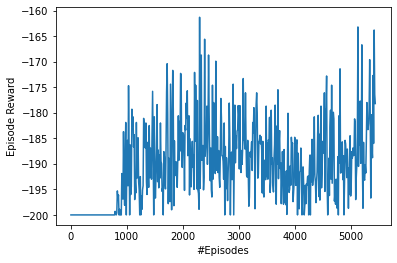

In [23]:
episode_num, epochs, mean_reward = load_Reward_Seq(RL_A4_path)
plt.plot(episode_num, mean_reward)
plt.xlabel('#Episodes')
plt.ylabel('Episode Reward')

Text(0, 0.5, 'Reward')

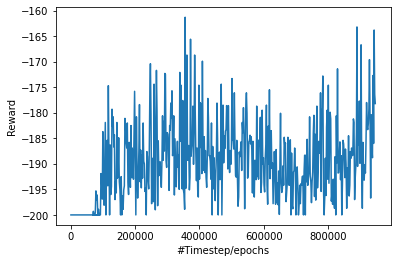

In [24]:
episode_num, epochs, mean_reward = load_Reward_Seq(RL_A4_path)
plt.plot(epochs, mean_reward)
plt.xlabel('#Timestep/epochs')
plt.ylabel('Reward')

In [25]:
mountain_car_agent.train_net,mountain_car_agent.target_net, mountain_car_agent.optimizer, epochs  = load_checkpoint(RL_A4_path, 
                                                                                             mountain_car_agent.train_net,
                                                                                             mountain_car_agent.target_net , 
                                                                                             mountain_car_agent.optimizer)

In [36]:
total_episodes

5000

# Action for given Velocity & Position 

In [26]:
state_sample = env.observation_space.sample()

print('position is {} , velocity is {}'.format(state_sample[0], state_sample[1]))
state_sample = torch.FloatTensor(state_sample).to(device)
action = mountain_car_agent.train_net(state_sample)#
print(action)
print('ACTION --> Accelerate to the left --> {}; Don’t accelerate --> {}; Accelerate to the right --> {}'.format(action[0], action[1], action[2]))

position is -0.43965962529182434 , velocity is 0.04299159720540047
tensor([-9.3661, -9.3483, -9.3245], device='cuda:0', grad_fn=<AddBackward0>)
ACTION --> Accelerate to the left --> -9.366130828857422; Don’t accelerate --> -9.348329544067383; Accelerate to the right --> -9.324504852294922


In [27]:
position_array , velocity_array, action_op   = [],[],[]

for i in range(10000):
  state_sample = env.observation_space.sample()
  position_array.append(state_sample[0])
  velocity_array.append(state_sample[1])

  state_sample = torch.FloatTensor(state_sample).to(device)
  action =  mountain_car_agent.target_net(state_sample)#.max(0)[1]
  action_op.append(list(action.detach().cpu().numpy()))
import pandas as pd  
dd = pd.DataFrame({'position':position_array,'velocity':velocity_array,'action':action_op})
dd['action_max'] = dd['action'].apply(lambda x : np.argmax(x))

In [28]:
device # device(type='cuda') when running this part

device(type='cuda')

In [29]:
dd.head(5)

,position,velocity,action,action_max
0,-0.949502,-0.050027,"[-8.910473, -8.887466, -8.967104]",1
1,0.352951,-0.009176,"[-8.417269, -8.41489, -8.319368]",2
2,-0.313146,0.020616,"[-9.58803, -9.594004, -9.573837]",2
3,-0.951233,-0.020433,"[-9.260187, -9.257908, -9.27662]",1
4,-0.094797,0.038804,"[-9.168609, -9.106361, -9.043468]",2


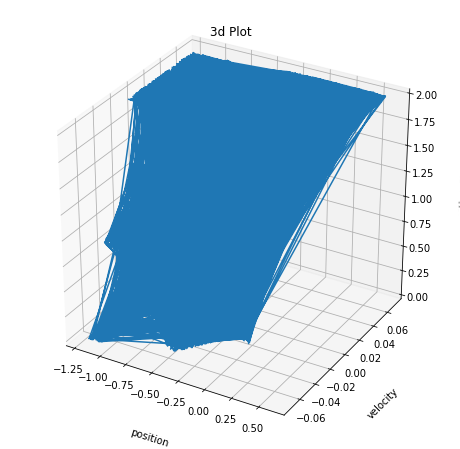

In [30]:
fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection='3d')
ax.grid()

ax.plot3D(dd['position'], dd['velocity'], dd['action_max'])
ax.set_title('3d Plot')

# Set axes label
ax.set_xlabel('position', labelpad=20)
ax.set_ylabel('velocity', labelpad=20)
ax.set_zlabel('action_max', labelpad=20)

plt.show()

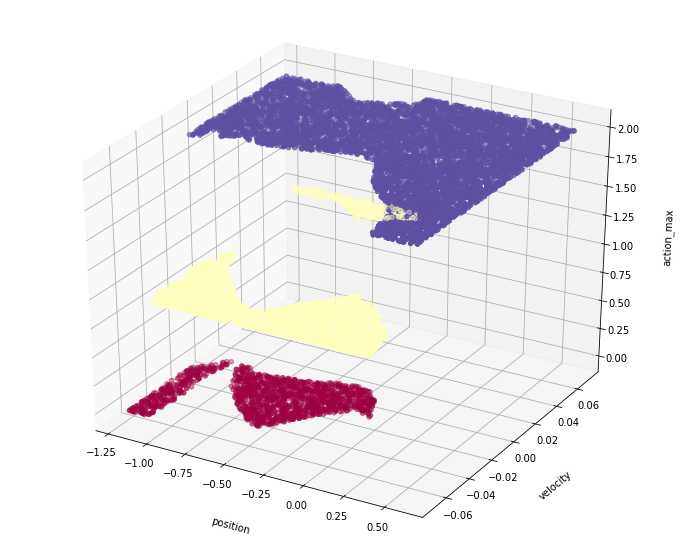

In [31]:
fig = plt.figure(figsize = (12,10))
ax = plt.axes(projection='3d')

x, y = dd['position'], dd['velocity']
#X, Y = np.meshgrid(x, y)
Z =  dd['action_max']
#surf = ax.plot_surface(X, Y, Z, cmap = plt.cm.cividis)
ax.scatter3D(x, y, Z, c=Z, cmap=plt.cm.get_cmap('Spectral') )#plt.cm.cividis);

# Set axes label
ax.set_xlabel('position', labelpad=20)
ax.set_ylabel('velocity', labelpad=20)
ax.set_zlabel('action_max', labelpad=20)

#fig.colorbar(surf, shrink=0.5, aspect=8)

plt.show()

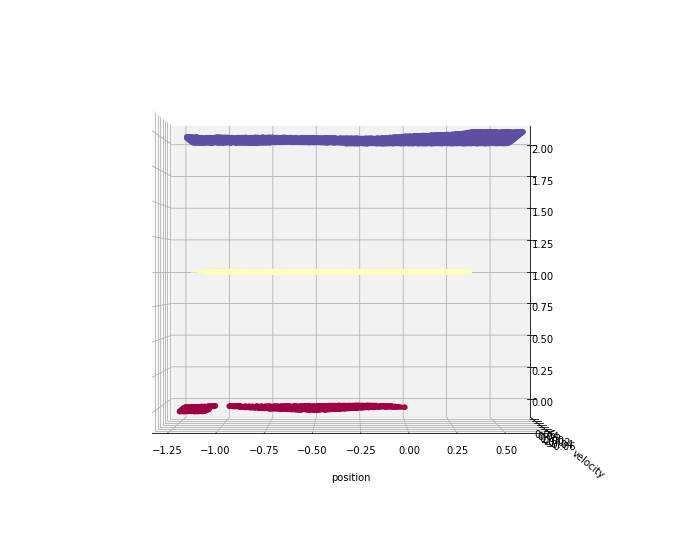

In [32]:
fig = plt.figure(figsize = (12,10))
ax = plt.axes(projection='3d')

x, y = dd['position'], dd['velocity']
#X, Y = np.meshgrid(x, y)
Z =  dd['action_max']
#surf = ax.plot_surface(X, Y, Z, cmap = plt.cm.cividis)
ax.scatter3D(x, y, Z, c=Z, cmap=plt.cm.get_cmap('Spectral') )#plt.cm.cividis);

# Set axes label
ax.set_xlabel('position', labelpad=20)
ax.set_ylabel('velocity', labelpad=20)
ax.elev = 0
ax.azim = -90
plt.show()

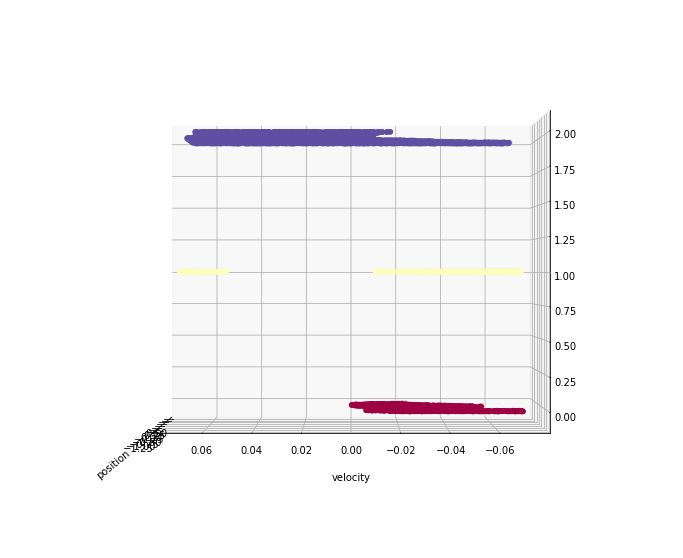

In [33]:
fig = plt.figure(figsize = (12,10))
ax = plt.axes(projection='3d')

x, y = dd['position'], dd['velocity']
#X, Y = np.meshgrid(x, y)
Z =  dd['action_max']
#surf = ax.plot_surface(X, Y, Z, cmap = plt.cm.cividis)
ax.scatter3D(x, y, Z, c=Z, cmap=plt.cm.get_cmap('Spectral') )#plt.cm.cividis);

# Set axes label
ax.set_xlabel('position', labelpad=20)
ax.set_ylabel('velocity', labelpad=20)
ax.elev = 0
ax.azim = 180
plt.show()

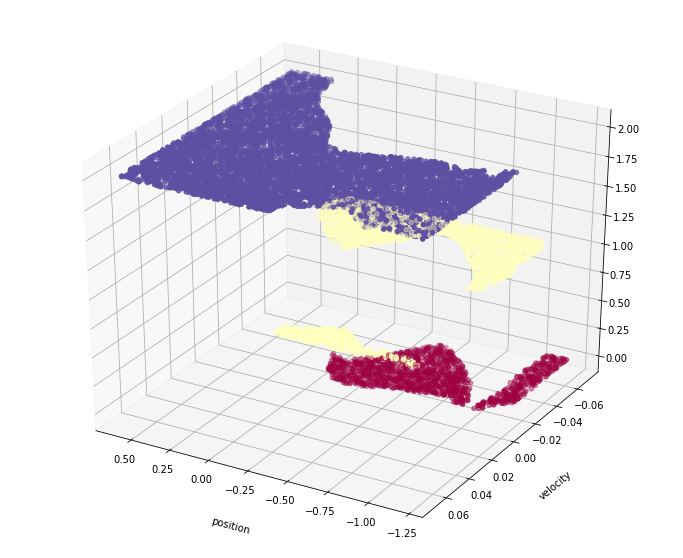

In [34]:
fig = plt.figure(figsize = (12,10))
ax = plt.axes(projection='3d')

x, y = dd['position'], dd['velocity']
#X, Y = np.meshgrid(x, y)
Z =  dd['action_max']
#surf = ax.plot_surface(X, Y, Z, cmap = plt.cm.cividis)
ax.scatter3D(x, y, Z, c=Z, cmap=plt.cm.get_cmap('Spectral') )#plt.cm.cividis);

# Set axes label
ax.set_xlabel('position', labelpad=20)
ax.set_ylabel('velocity', labelpad=20)
ax.elev = 30
ax.azim = 120
plt.show()

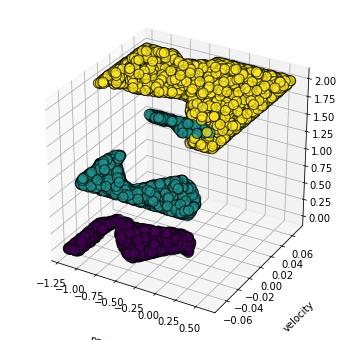

In [35]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
x,y = dd['position'], dd['velocity']
#X, Y = np.meshgrid(x, y)
Z =  dd['action_max']


fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, Z,
           linewidths=1, alpha=.7,
           edgecolor='k',
           s = 100,
           c=Z)
ax.set_xlabel('position', labelpad=20)
ax.set_ylabel('velocity', labelpad=20)
ax.set_zlabel('action_max', labelpad=20)
plt.show()
